# Fast track reconstruction in drift tube detectors


GRUPPO 15:
Lorenzo Borella, Mattia Ceravolo, Marco Giunta, Samuele Pio Lipani.

# Part 0

In [1]:
import pandas as pd
import numpy as np
import timeit as t
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import optimize

import time

In [2]:
start = time.time()

In [3]:
#DATA AQUISITION
dataset = pd.read_csv("data_000000.txt")

samples = dataset.shape[0]
print("Number of total hits:",samples)
# sono le righe totali del dataset. Esse corrispondono al numero totale di hits ma non di eventi, bisogna infatti decidere quando accettare un evento o meno come compatibile con il passaggio di una particella attraverso il rivelatore
#ntriggers_mask = (dataset['TDC_CHANNEL'] == 137) | (dataset['TDC_CHANNEL'] ==138)
ntriggers = dataset[(dataset['TDC_CHANNEL'] == 137) | (dataset['TDC_CHANNEL'] == 138)].shape[0]
triggers = dataset[dataset['TDC_CHANNEL'] == 139].shape[0]
# i triggers sono costituiti da due tipologie di segnali: quelli degli scintillatori 137 e 138 e un'informazione, il trigger elettronico, che ci comunica quando sono state attivate almeno due celle allineate 
print("Number of trigger 139 activations:",triggers)
print("Percentage of trigger 139 wrt the total", triggers/samples*100)
#print("Percentage of trigger 137-8 wrt the total", dataset[ntriggers_mask].shape[0]/samples*100)
print("Percentage of trigger 137-8 wrt the total", ntriggers/samples*100)
total_orbits = dataset['ORBIT_CNT'].nunique()
print("Number of unique orbits:",total_orbits)
# le orbits corrispondono alle ore in cui il rivelatore è rimasto acceso. Quindi con il comando nunique si contano il numero totale di orbits in cui l'apparato è rimasto in funzione in quanto esso selezione quante volte sono presenti valori unici di ORBIT.

#GET MORE DATA

display(dataset)


Number of total hits: 1292126
Number of trigger 139 activations: 95258
Percentage of trigger 139 wrt the total 7.372191256889808
Percentage of trigger 137-8 wrt the total 0.18930042426203017
Number of unique orbits: 481613


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,1,116,1897414884,1533.0,24.0
1,1,1,71,1897414887,1650.0,21.0
2,1,1,67,1897414914,980.0,8.0
3,1,1,70,1897414922,1287.0,8.0
4,1,0,57,1897414922,2162.0,22.0
...,...,...,...,...,...,...
1292121,1,1,139,1920940255,2514.0,0.0
1292122,1,1,35,1920940255,2512.0,16.0
1292123,1,1,37,1920940255,2513.0,5.0
1292124,1,1,105,1920940255,2510.0,17.0


I trigger sono quelli che hanno come TDC_CHANNEL 137,138,139. Attenti però che i due con 137 e 138 corrispondono all'informazione dei due scintillaori posti sopra e sotto il rivelatore che confermano il passaggio di una particella o meno mentre TDC_CHANNEL=139 equivale alla rivelazione di una particella attraverso celle allineate. Allora gli hits accompagnati da 139 sono: o sicuramente una particella che attraversa il rivelatore oppure delle celle che si sono attivate casualmente contemporaneamente ma corrispondenti a particelle diverse. I trigger con 137 e 138 crediamo che siano sicuramente eventi buoni al fine del passaggio di una particella nel rivelatore.
Tuttavia si osserva che le percentuali di hits che presentano i due diversi tipi di trigger non sono confrontabili dunque decidiamo fin da subito di prendere come buoni gli eventi che conterranno soltanto TDC_CHANNEL=139 e non gli altri due che sono più rari.

Si osserva infatti che mentre i trigger 139 sono il 7% degli hits nel dataset quelli 137-8 sono soltanto $\approx 0.18$%

Abbiamo inserito i dati in un DataFrame di Pandas ed abbiamo stampato i parametri di interesse iniziali: numero di hits totali, numero di attivazioni dei trigger, numero di valori unici di ORBIT_CNT. (DATI DA INSERIRE ALLA FINE)

(FARE COMMENTI SULLA SCELTA DEI DATI: CALIBRATION E PHYSICS RUN).

In [4]:
#add ORBIT TIME column
dataset['TIME'] = dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30 #time at fixed orbit
# si fa la conversione temporale da ciò che è presente nel dataset al tempo in nanosecondi

#add DETECTOR column

fpga = dataset['FPGA'] == 1 #condition on FPGA
channel = (dataset['TDC_CHANNEL'] > 64) & (dataset['TDC_CHANNEL'] <= 128) #condition on TDC_CHANNEL
trigger = dataset['TDC_CHANNEL'] == 139 #condition on electronic trigger

detectors = [~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel] #list of conditions
for i in range(len(detectors)) : 
    dataset.loc[detectors[i],'DETECTOR'] = i+1 
# detectors è una lista contenente le condizioni per assegnare il numero al detector in funzione della mappatura dei tdc_channels. Ad esempio il primo elemento sono le condizioni per assegnare il detector numero uno cioè se fpga=0 e (and logico intersezione) il canale non è in 'channel' (tra uno e 64)
dataset.loc[trigger,'DETECTOR'] = 0 
# Per distinguere i trigger dagli hits imponiamo 'DETECTOR'=0.
# Tra le condizioni viste prima non sono compresi i td_channel dei trigger quindi bisogna assegnarli a mano. Inoltre poichè filtreremo successivamente per il trigger elettronico non ci curiamo dei trigger 137 e 138 essendo la condizione 'trigger' valida solo per i 139

#add LAYER column
# Dalla figura del documento si osserva una numerazione a saltare delle celle nei quattro layers. Innanzitutto i valori che vanno da 65 a 128 sono congruenti al range 1-64 modulo 64 quindi ci possiamo concentrare direttamente sui valori di TDC_CHANNEL in 1-64. Numeriamo i quattro layer dal primo (in basso) all'ultimo in modo che:
# 4n per n in 1-16 sono le celle nel layer 1
# 4n+2 layer 2
# 4n+3 layer 3
# 4n+1 layer 4 
# dividendo per quattro pertanto avrò come resto i valori, in ordine di layer, 0 2 3 1 
rest = dataset['TDC_CHANNEL']%4 # costruisco una serie di resti a partire dai canali divisi per quattro
# scrivo poi una funzione che applicata a rest ritorna i layer corrispondenti, utilizzo broadcasting attraverso un dizionario che chiamo replace
dic_replace = {0:1, 2:2, 3:3, 1:4}
dataset['LAYER'] = rest
dataset['LAYER'].replace(dic_replace, inplace=True)
# la lista layers comprende le condizioni da imporre per assegnare il giusto layer agli hits nel dataframe. Sappiamo per costruzione che ciascun layer è formato da 16 celle, quindi un detector avrà complessivamente 64 celle attivabili. I detector sono quattro e tramite la mappatura usata precedentemente capiamo perchè i tdc_channels non si fermano a 64 ma proseguono fino a 128 (anche con l'ausilio di fpga=0,1 che permette di duplicare le 128 celle nei tdc_channels).
dataset.loc[trigger,'LAYER'] = 0 
# Stesso procedimento di prima per 'DETECTOR'
    
#drop useless columns HEAD,FPGA
dataset = dataset.drop(['HEAD','FPGA'],axis=1) 

dataset

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,116,1897414884,1533.0,24.0,38345.000000,4.0,1
1,71,1897414887,1650.0,21.0,41267.500000,4.0,3
2,67,1897414914,980.0,8.0,24506.666667,4.0,3
3,70,1897414922,1287.0,8.0,32181.666667,4.0,2
4,57,1897414922,2162.0,22.0,54068.333333,1.0,4
...,...,...,...,...,...,...,...
1292121,139,1920940255,2514.0,0.0,62850.000000,0.0,0
1292122,35,1920940255,2512.0,16.0,62813.333333,3.0,3
1292123,37,1920940255,2513.0,5.0,62829.166667,3.0,4
1292124,105,1920940255,2510.0,17.0,62764.166667,4.0,4


Per prima cosa abbiamo inserito all'interno del DataFrame le colonne TIME, DETECTOR e LAYER.

I valori assegnati nella colonna TIME corrispondono alla trasformazione dei tempi associati a ciascuna hit in ns . Per la derivazione di ognuno di questi valori non è stato considerato il valore di ORBIT_CNT, in quanto inutile per il proseguimento del progetto.

Per quanto riguarda la colonna DETECTOR, i valori sono stati assegnati secondo la mappatura prestabilita:
* Detector 1 $\rightarrow$ FPGA 0, TDC_CHANNEL in [1-64]
* Detector 2 $\rightarrow$ FPGA 0, TDC_CHANNEL in [65-128]
* Detector 3 $\rightarrow$ FPGA 1, TDC_CHANNEL in [1-64]
* Detector 4 $\rightarrow$ FPGA 1, TDC_CHANNEL in [65-128]

In corrispondenza delle attivazioni dei trigger è stato inserito un valore DETECTOR=0, in quanto questi non sono univocamente associabili ad alcun detector.

I valori inseriti nella colonna LAYER sono stati dedotti dai corrispettivi valori di TDC_CHANNEL, attuando alcune considerazioni sulla numerazione delle singole celle. Anche in questo caso, in corrispondenza delle attivazioni dei trigger, è stato assegnato un valore LAYER=0

Infine abbiamo eliminato le colonne HEAD e FPGA, non più utili ai fini del progetto.

Al fine di tradurre il nostro DataFrame in termini di singoli eventi, abbiamo apportato una serie di tagli, utili in seguito ad identificare più accuratamente i singoli eventi.

Per prima cosa abbiamo raggruppato i dati in termini del valore di ORBIT_CNT comune, dopodiché abbiamo eliminato tutti i gruppi che contenevano un numero di hits non sufficiente a descrivere un evento fisico.
Questo primo taglio ci ha portato ad avere una mole di dati utili pari al 68% del dataset originale.
(INSERIRE I DATI FINALI)


(BISOGNA DIRE CHE QUESTO TAGLIO E' UTILE SOLO PER FORNIRE AL TAGLIO SUCCESSIVO UNA MOLE INFERIORE DI DATI. HO PROVATO A FARE SOLO IL TAGLIO DELLA CELLA DOPO MA CI METTE UNA VITA!)

Il primo taglio elimina quelle orbite che all'interno non hanno almeno tre hits, quindi ancora non stiamo parlando di eventi. Perché questa scelta? Per parlare di eventi abbiamo bisogno che le celle nei layers si attivino al passaggio di una particella per tracciarne la traiettoria. Se chiedessimo l'attivazione di almeno due celle, due hits in un orbit, staremmo considerando il caso in cui la traiettoria della particella passa per due punti (cioè i due hits delle due celle attivate). Questo è un caso banale perchè per due punti è sempre possibile far passare una retta, forzeremmo così quegli eventi che potrebbero essere spuri ad essere fisici aggiungendo traiettorie a quelle reali. Allora decidiamo di considerare il caso di almeno tre hits in una stessa orbit, un limite inferiore ma non superiore per adesso.

In [5]:
# In questo modo, anziché lavorare sul dataframe, casto una riga o colonna dello stesso ad un array di numpy specificando anche il tipo di dato e poi lavoro sull'array. Infine sostisuisco la riga o la nuova colonna nel dataframe con quella su cui ho lavorato.

#ciao=dataset.loc[1].to_numpy(dtype=float, copy=False)
#ciao[3]=0
#dataset.loc[1]=ciao

```python
dataset.groupby(['ORBIT_CNT']).groups 
```

Restituisce un dizionario le cui chiavi sono le diverse orbits e come valori per ogni chiave gli indici corrispondenti alle volte in cui le orbits compaiono all'interno del dataset. Ad esempio 
```python
dataset.groupby(['ORBIT_CNT']).groups.keys()
```
ritorna lo stesso risultato di ```python dataset['ORBIT_CNT'].nunique() ```
Considerando il gruppo specifico di cui sotto osservo che esso contiene un hit soltanto
```python
dataset.groupby(['ORBIT_CNT']).groups[1897414884] 
```
Bisogna filtrare inizialmente il dataset in modo da eliminare quei gruppi contenenti meno di tre hits. Posso utilizzare:
```python
dataset.groupby(['ORBIT_CNT']).filter(lambda x : len(x) >= 3)
```

In [6]:
#FIRST CUT

#function to cut groups smaller than 3 hits
def cut(group) :
    if group.shape[0] > 2 : return group
    else : return None
# questa funzione è molto meno pesante computazionalmente rispetto alla precedente quando applicata al dataset tramite il metodo apply

#filter dataset by length                          
filtered1=dataset.groupby(['ORBIT_CNT'],group_keys=False)\
                 .apply(cut)\
                 .dropna()\
                 .reset_index()\
                 .drop(['index'],axis=1)
# dropna elimina quegli elementi nel dataframe che hanno "not a number" come valore. 
# reset index, poiché il dataframe è stato filtrato ristabilisce l'enumerazione ordinata tramite indici che si era persa a causa dei drop delle righe. Quando si utilizza reset index viene aggiunta una colonna nel dataframe chiamata 'index' contenente gli indici precedenti non più ordinati, la eliminiamo tramite il metodo drop poichè ridondante in quanto l'informazione è già contenuta nella prima nuova colonna del dataframe

orbits1 = filtered1['ORBIT_CNT'].nunique()

print("Number of unique orbits:", orbits1)
print("Samples in reduced dataset:", filtered1.shape[0])
print("Percentage of the original dataset:", filtered1.shape[0]*100/samples,"%")



if orbits1 > triggers : 
    print("NOTE:There are orbits with no trigger activation!")#check

filtered1

Number of unique orbits: 118626
Samples in reduced dataset: 879478
Percentage of the original dataset: 68.06441477069573 %
NOTE:There are orbits with no trigger activation!


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
...,...,...,...,...,...,...,...
879473,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0
879474,139.0,1.920940e+09,2514.0,0.0,62850.000000,0.0,0.0
879475,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0
879476,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0


In seguito abbiamo pensato di ridurre ulteriormente il dataset considerando i dati che, sempre all'interno di una singola orbita, avessero almeno una hit corrispondente ad un'attivazione del trigger. Questo tipo di selezione non ha escluso la possibilità di avere più attivazioni di trigger all'interno dello stesso valore di ORBIT_CNT.

Grazie a questa selezione, i dati rimanenti corrispondono al 60% dei dati iniziali.

(INSERIRE DATI ALLA FINE)

In [7]:
#SECOND CUT

#function that selects events with trigger activation
def trigger(group) :
    if (group['DETECTOR'] != 0).all() : 
        return None
    else : 
        return group
    
#filter dataset by trigger activation                                      
filtered2 = filtered1.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(trigger)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)#LONG RUNTIME!!!


orbits2 = filtered2['ORBIT_CNT'].nunique()

print("Number of unique orbits:", orbits2)
print("Samples in reduced dataset:", filtered2.shape[0])
print("Percentage of the original dataset:", filtered2.shape[0]*100/samples,"%")

#check
if orbits2 > triggers :
    print("ERROR!")
else :
    print("NOTE:Multiple trigger activations in the same ORBIT_CNT!")
    
filtered2

Number of unique orbits: 90889
Samples in reduced dataset: 776404
Percentage of the original dataset: 60.08732894470044 %
NOTE:Multiple trigger activations in the same ORBIT_CNT!


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
...,...,...,...,...,...,...,...
776399,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0
776400,139.0,1.920940e+09,2514.0,0.0,62850.000000,0.0,0.0
776401,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0
776402,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0


Abbiamo in seguito calcolato quanti gruppi, corrispondenti ad un medesimo valore di ORBIT_CNT, contenessero al loro interno un numero di attivazioni di trigger maggiori di 1.

In [8]:
#compute number of orbits with multiple activation
def multiple(group) :
    if group[group['DETECTOR']==0].shape[0] > 1 : 
        return group
    else: 
        return None
    
#filter dataset by trigger activation                                      
multiple = filtered2.groupby(['ORBIT_CNT'],group_keys=False)\
                    .apply(multiple)\
                    .dropna()\
                    .reset_index()\
                    .drop(['index'],axis=1)#LONG RUNTIME!!!


orbitsm = multiple['ORBIT_CNT'].nunique()

print("Number of unique orbits:", orbitsm)
print("Samples in reduced dataset:", multiple.shape[0])
print("Percentage of the original dataset:", multiple.shape[0]*100/samples,"%")

Number of unique orbits: 4129
Samples in reduced dataset: 76297
Percentage of the original dataset: 5.904764705609205 %


Una volta convinti di non avere a che fare con una mole considerevole di dati, abbiamo deliberatamente deciso di non considerare questi casi per semplicità. 
Ci aspettiamo che per ogni orbit ci sia al più un evento fisico cioè il passaggio di una particella. Poichè l'attraversamento di una particella nel rivelatore non è frequente allora è ragionevole considerare soltanto un evento per orbita. Caratterizziamo un evento tramite l'attivazione di un trigger, TDC_CHANNEL=139 trigger elettronico (avendo già in precedenza escluso i trigger 137 e 138 visto la loro rarità nel dataset). Se ci dovessero essere più attivazioni di trigger all'interno di una stessa orbita le motivazioni possono essere ad esempio:

-sono effettivamente passate due particelle e il rivelatore le ha riconosciute entrambe con risoluzione temporale pari alla distanza in termini di nanosecondi dei due trigger. Tuttavia è molto raro osservare due particelle passare in uno stesso detector "contemporaneamente" pertanto escludiamo questo caso da quelli accettabili;

-una particella passa attraverso il detector, si attiva un trigger e a causa di rumore e segnale residuo dal passaggio di quest ultima un altro trigger si attiva. In questo caso si possono attivare più trigger ma tra questi in ogni gruppo scegliamo quello che si è attivato per primo.

Potremmo, anzichè applicare un criterio di vicinanza temporale tra le hits e il trigger elettronico, inizialmente tagliare quelle orbite che contengono più di un'attivazione di trigger e proseguire. A supporto di questa scelta ci viene incontro la percentuale esigua, $\approx 6$%, di orbite in cui si presentano più di un trigger.

In [9]:
#cut orbits which have multiple trigger activations

def multiple_orbits(group) :
    if group[group['DETECTOR']==0].shape[0] > 1 : 
        return None
    else : 
        return group
    
#filter dataset by trigger activation                                      
filtered3 = filtered2.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(multiple_orbits)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)#LONG RUNTIME!!!


orbits3 = filtered3['ORBIT_CNT'].nunique()

print("Number of unique orbits:", orbits3)
print("Samples in reduced dataset:", filtered3.shape[0])
print("Percentage of the original dataset:", filtered3.shape[0]*100/samples,"%")

filtered3

Number of unique orbits: 86760
Samples in reduced dataset: 700107
Percentage of the original dataset: 54.182564239091235 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
...,...,...,...,...,...,...,...
700102,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0
700103,139.0,1.920940e+09,2514.0,0.0,62850.000000,0.0,0.0
700104,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0
700105,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0


Abbiamo posizionato i valori dei tempi all'interno di ogni gruppo in ordine crescente. (E' INUTILE IN QUESTO MOMENTO)

In [10]:
#useless at this point

#sort each group by time

ordered = filtered3.groupby(['ORBIT_CNT'],group_keys=False)\
                   .apply(lambda x: x.sort_values(['TIME']))\
                   .reset_index()\
                   .drop(['index'],axis=1) #LONG RUNTIME!!!

ordered

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
...,...,...,...,...,...,...,...
700102,102.0,1.920940e+09,2510.0,22.0,62768.333333,4.0,2.0
700103,38.0,1.920940e+09,2512.0,10.0,62808.333333,3.0,2.0
700104,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0
700105,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0


A questo punto alcuni gruppi potrebbero ancora contenere hits corrispondenti a detector differenti ma avvenute nella stessa ORBIT_CNT. Poichè abbiamo raggruppato gli eventi attraverso una singola attivazione di trigger ci aspettiamo che in un'orbit avvenga la rivelazione della traiettoria di una particella. Inoltre poichè abbiamo limitato ogni orbit ad una sola trigger activation il detector che si è acceso al passaggio della particella dovrebbe essere uno solo. Se trovassimo pertanto hits vicine temporalmente, un trigger 139 ma più detector allora è probabile che uno solo di questi sia quello che ha realmente osservato la particella. 
Per ogni evento decidiamo di tenere le hits associate al maggior numero di volte che compare un detector a discapito di un altro. Se ad esempio il detector 1 dovesse comparire tre volte mentre il detector 2 soltanto una, oltre alle motivazioni fisiche già addotte nelle celle precedenti, sceglieremmo di tenere le hits associate al numero 1.

Questo taglio ci ha permesso di conservare il 38% del dataset originale come dati utili ai fini del nostro progetto.(INSERIRE DATI)

In [11]:
# ESEMPIO CON IL PRIMO EVENTO 
# il metodo apply lavora sui singoli gruppi del groupby allora per fare un esempio considero soltanto un gruppo cioè:
df_1 = ordered.loc[ordered.groupby(['ORBIT_CNT']).groups.get(1897414934.0)]
notrigger_ex = df_1.drop(df_1[df_1['DETECTOR']==0].index) # il dataframe risultante è senza trigger, serve creare una copia del dataframe senza trigger prima di altre operazioni perchè poi alla fine verranno droppate quelle righe nel dataframe iniziale che non contengono il detector in maggioranza nell'evento. Se lasciassimo i trigger li perderemmo nel dataframe finale con le operazione successive.  
detector_ex = notrigger_ex.DETECTOR.mode().values # .DETECTOR seleziona la colonna detector e .mode() calcola quel valore che compare più volte al suo interno (nel nostro caso è proprio il detector a cui dobbiamo assegnare l'evento fisico)
indices_ex = notrigger_ex[notrigger_ex['DETECTOR']!=detector_ex[0]].index # infatti è vuoto perchè è rimasto soltanto il detector uno 
df_1 = df_1.drop(indices_ex)
df_1

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
5,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
6,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0


In [12]:
#FOURTH CUT
#function that cleans the events
def clean(group):
    
    group1 = group.drop(group[group['DETECTOR'] == 0].index) #event without trigger
    
    detector = group1.DETECTOR.mode().values #value of most common detector
    
    indices = group1[group1['DETECTOR'] != detector[0]].index #indices of event not corresponding to major detector
    group = group.drop(indices) #clean event
    
    return group

#clean the events
filtered4 = ordered.groupby(['ORBIT_CNT'],group_keys=False)\
                   .apply(clean)\
                   .dropna()\
                   .reset_index()\
                   .drop(['index'],axis=1) #LONG RUNTIME!!!


orbits4 = filtered4['ORBIT_CNT'].nunique()
hits4 = filtered4.shape[0]
print("Number of unique orbits:", orbits4)
print("Samples in reduced dataset:", hits4)
print("Percentage of the original dataset:", hits4*100/samples,"%")


filtered4

Number of unique orbits: 86760
Samples in reduced dataset: 503050
Percentage of the original dataset: 38.931961743668964 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
...,...,...,...,...,...,...,...
503045,106.0,1.920940e+09,2507.0,24.0,62695.000000,4.0,2.0
503046,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0
503047,105.0,1.920940e+09,2510.0,17.0,62764.166667,4.0,4.0
503048,102.0,1.920940e+09,2510.0,22.0,62768.333333,4.0,2.0


### Attenzione
Con questo quarto filtro può capitare che appaiano nel dataset degli eventi che invece già dal primo cut avremmo voluto eliminare.
Analizzando ogni singolo hit all'interno di uno stesso gruppo scartiamo quelli che corrispondono al detector che compare meno volte e quindi ha minore rilevanza e non è accettabile fisicamente; tuttavia se in un gruppo ci fossero soltanto tre hits delle quali due appartengono ad un detector e una ad un altro allora l'evento rimanenente avrebbe soltanto due hits il che è in contraddizione con quanto richiesto dal primo filtro in assoluto. Le strade da poter seguire sono due:

-invertire l'applicazione dei filtri in modo da eliminare solo successivamente all'assegnazione del detector gli eventi contenenti meno di tre hits. Questa procedura risulta essere molto dispendiosa computazionalmente pertanto decidiamo di utilizzare la seconda;
-applicare una seconda volta il "first cut" visto qualche cella prima al dataset filtrato "filtered 4". La differenza tra il nuovo dataframe e il precedente è soltanto di qualche decina di hits.


In [13]:
filtered4 = filtered4.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(cut)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)
print("There are:", hits4-filtered4.shape[0], "samples less than the previous cut")

There are: 6 samples less than the previous cut


### Esempi di eventi 
Questi due esempi rappresentano due eventi corrispondenti ai due tempi $50700 ns$ e $70300 ns$ in due ore però diverse (ORBIT_CNT diverse)

In [14]:
display(filtered4.loc[filtered4.groupby(['ORBIT_CNT']).groups.get(1897414934.0)])
# dentro il loc si trova la lista di indici corrispondenti agli hits nel gruppo dell'orbita 1897414934.0
display(filtered4.loc[filtered4.groupby(['ORBIT_CNT']).groups.get(1897415301.0)])
# oppure anzichè specificare l'orbita posso direttamente scrivere [*filtered4.groupby(['ORBIT_CNT']).groups.keys()][0] per scegliere la prima oppure in maniera ancora più semplice partendo dal dataframe iniziale: filtered4['ORBIT_CNT'].unique()[0] infatti 
# [*filtered4.groupby(['ORBIT_CNT']).groups.keys()][0] == filtered4['ORBIT_CNT'].unique()[0] ritorna True

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
5,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0
6,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
7,87.0,1.897415e+09,2798.0,9.0,69957.5,2.0,3.0
8,86.0,1.897415e+09,2802.0,27.0,70072.5,2.0,2.0
9,89.0,1.897415e+09,2807.0,27.0,70197.5,2.0,4.0
10,88.0,1.897415e+09,2810.0,24.0,70270.0,2.0,1.0
11,139.0,1.897415e+09,2812.0,0.0,70300.0,0.0,0.0


Potremmo ridurre ancora di più il dataset applicando il seguente taglio:
chiediamo che le hits in uno stesso evento appartengano tutte a layer diversi e questi siano, almeno una volta, tutti attivi durante il passaggio della particella. In questo modo però restringiamo molto il campo di analisi perchè chiediamo che almeno una cella in ogni layer segnali l'evento fisico. Esistono tuttavia eventi in cui non tutti i layer riconoscono l'arrivo della particella, ricordiamo che abbiamo comunque bisogno di almeno tre layer attivi altrimenti non potremmo tracciare una retta per i punti da cui proviene il segnale nelle celle!
Ricordiamo inoltre che una condizione fisica fondamentale per accettare un evento come fisico è quella di avere traiettorie "quasi verticali". L'apparato sperimentale infatti è sensibile a traiettorie al più inclinate di 45°-50° pertanto se dovessimo trovare "buchi" nell'attivazione dei layer allora gli eventi associati a questi gruppi sarebbero molto probabilmente corrispondenti a tracce oltre l'inclinazione accettabile. Per avere contezza degli ordini di grandezza in gioco contiamo questi casi a discapito di quelli in cui tutti i layer sono attivi.

In [15]:
# questa funzione conta le orbits in cui ci sono quattro layer attivati. Calcoliamo poi la percentuale di eventi siffatti rispetto al totale (unique orbits)
def countlayers(group):
    if group['LAYER'].nunique() > 3:
        return group
    else: return None
lessthan3df = filtered4.groupby(['ORBIT_CNT'],group_keys=False)\
                       .apply(countlayers)\
                       .dropna()\
                       .reset_index()\
                       .drop(['index'],axis=1)

lessthan3orbits = lessthan3df['ORBIT_CNT'].nunique()
print("Events having all four layers activated are:",lessthan3orbits/orbits4*100,"wrt the previous filtering procedure")

Events having all four layers activated are: 99.44213923467035 wrt the previous filtering procedure


In [16]:
# QUANTI SONO PERO I BUCHI NELL'UN PERCENTO 
def hole(group):
    if group['LAYER'].nunique() < 4:
        if ((group['LAYER']==1).any())and((group['LAYER']==2).any())and((group['LAYER']==4).any()) :
            return group
        elif ((group['LAYER']==1).any())and((group['LAYER']==3).any())and((group['LAYER']==4).any()) :
            return group
        else : 
            return None
    else : 
        return None 
holes = filtered4.groupby(['ORBIT_CNT'],group_keys=False)\
                 .apply(hole)\
                 .dropna()\
                 .reset_index()\
                 .drop(['index'],axis=1)
holes
#nholes = holes['ORBIT_CNT'].nunique()
#nholes 

""


In questo caso troviamo zero buchi nonostante ciò procediamo con il filtro che restituisce un dataframe nel quale siano attivi, in ogni orbita, almeno tre layer

In [17]:
#FIFTH CUT

def all_layers(group) :
    if group['LAYER'].nunique() > 2 :
        return group
    else :
        return None

filtered5 = filtered4.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(all_layers)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1) 


orbits5 = filtered5['ORBIT_CNT'].nunique()

print("Number of unique orbits:", orbits5)
print("Samples in reduced dataset:", filtered5.shape[0])
print("Percentage of the original dataset:", filtered5.shape[0]*100/samples,"%")


filtered5

Number of unique orbits: 86744
Samples in reduced dataset: 502930
Percentage of the original dataset: 38.92267472367246 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0
...,...,...,...,...,...,...,...
502925,106.0,1.920940e+09,2507.0,24.0,62695.000000,4.0,2.0
502926,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0
502927,105.0,1.920940e+09,2510.0,17.0,62764.166667,4.0,4.0
502928,102.0,1.920940e+09,2510.0,22.0,62768.333333,4.0,2.0


Infine decidiamo di procedere con un sesto filtro sulla base di quante hits appartengono allo stesso layer in ogni gruppo, cioè in ogni evento che abbiamo classificato. Poichè il rivelatore è costruito in modo da accettare soltanto traiettorie "quasi verticali", se in uno stesso layer si attivassero più celle sarebbe alquanto probabile osservare una traiettoria inclinata oltre il limite di sensibilità dello strumento. Inoltre se in uno stesso layer si attivassero più celle, anche contigue, non avremmo un criterio per sceglierne una a discapito di un'altra al fine di ricostruire la traiettoria della particella. Se scegliessimo una cella staremmo manomettendo l'evento forzandolo ad essere fisicamente accettabile. Interpretiamo pertanto questi eventi come errori di attivazione delle celle nei layer e per questa ragione li eliminiamo dal dataframe ottenuto dai precedenti filtri.

In [18]:
# SIXTH CUT 
def more_layers(group) : 
    if len(group['LAYER']) != len(set(group['LAYER'])) : 
        return None 
    else : 
        return group
# questa funzione utilizza i set. Per ogni gruppo controlla se la lunghezza della colonna layer castata a set sia diversa da quella non castata e se lo è allora ritorna None altrimenti il gruppo passa inalterato attraverso la condizione
filtered6 = filtered5.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(more_layers)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)
# raggruppando per orbite e layer applichiamo la funzione nell'argomento di filter che seleziona quei gruppi che hanno elementi con orbite e layer uguali a uno. Visto che il raggruppamento "più a basso livello" è il secondo in pratica il filtro agisce su questi ultimi gruppi: essi presentano una sola orbita per certo ma un layer non per forza si presenta una sola votla quindi i suddetti casi vengono eliminati.
orbits6 = filtered6['ORBIT_CNT'].nunique()

print("Number of unique orbits:", orbits6)
print("Samples in reduced dataset:", filtered6.shape[0])
print("Percentage of the original dataset:", filtered6.shape[0]*100/samples,"%")

filtered6

Number of unique orbits: 60160
Samples in reduced dataset: 297946
Percentage of the original dataset: 23.058587165647932 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,87.0,1.897415e+09,2798.0,9.0,69957.500000,2.0,3.0
1,86.0,1.897415e+09,2802.0,27.0,70072.500000,2.0,2.0
2,89.0,1.897415e+09,2807.0,27.0,70197.500000,2.0,4.0
3,88.0,1.897415e+09,2810.0,24.0,70270.000000,2.0,1.0
4,139.0,1.897415e+09,2812.0,0.0,70300.000000,0.0,0.0
...,...,...,...,...,...,...,...
297941,26.0,1.920940e+09,545.0,21.0,13642.500000,3.0,2.0
297942,25.0,1.920940e+09,546.0,2.0,13651.666667,3.0,4.0
297943,139.0,1.920940e+09,548.0,0.0,13700.000000,0.0,0.0
297944,24.0,1.920940e+09,550.0,20.0,13766.666667,3.0,1.0


A questo punto però gli eventi selezionati non sono sempre associabili a delle traiettorie rettilinee della perticella. Per rappresentare graficamente le hit all'interno del detector abbiamo definito alcune funzioni.
La prima associa alla numerazione predefinita delle celle delle coordinate spaziali bidimensionali, corrispondenti idealmente ai centri di ogni cella.

In [48]:
#function to draw hit cells
# prende le hit e vi associa il centro di ogni cella intercettata dal passaggio della particella. L'argomento è un singolo evento
def centres(ev):
    
    ev=ev.drop(ev[ev['DETECTOR'] == 0].index).reset_index().drop(['index'],axis=1) #drop the trigger hit
    
    dx=1
    dy=1/2
    
    x = np.zeros(ev.shape[0])
    y = np.zeros(ev.shape[0])
    # questi due array sono della lunghezza delle hits

    if (ev['TDC_CHANNEL']>64).all() : 
        #ev['TDC_CHANNEL'] = ev['TDC_CHANNEL']-64 # traslo queoi tdc_channel che sono nel range 65-128 nel range 1-64
        ev['TDC_CHANNEL'] -= 64 #più leggibile così?

    #calculate coordinates of centers
    for i in range(ev.shape[0]): # hit per hit
        
        layer = ev.loc[i,'LAYER']
        channel = ev.loc[i,'TDC_CHANNEL']

        if layer == 1 : #livello di altezza minima nella nostra convenzione
            x[i] = channel/4
            y[i] = 1/4
        
        elif layer == 2 :
            x[i] = (channel+2)/4 + dx/2 #+dx/2 perché il secondo livello è traslato un po' verso destra
            y[i] = 3/4 #1/4 più dy
        
        elif layer == 3 :
            x[i] = (channel+1)/4
            y[i] = 5/4
        
        elif layer == 4 : #il layer più alto nella nostra convenzione
            x[i] = (channel+3)/4 + dx/2 #+dx/2 perché il quarto livello è traslato un po' verso destra
            y[i] = 7/4
        
            
    return [x,y]
    #sommare un termine layer dependent (1:0, 2:2 ecc. tipo il dic_replace in alto) e poi dividere per 4 serve solo a ripristinare una numerazione "tradizionale" per i rettangoli in ciascun layer abbandonando la convenzione "a saltare" di Zanetti. Infatti in ogni livello passando da una cella a quella subito a destra si salta sempre di +4 per quanto riguarda TDC_CHANNEL, quindi chiaramente dividendo per 4 non faccio altro che contare le celle su uno stesso layer in modo tradizionale (e siccome questa divisione non dà numeri interi perché 3 layer su 4 non sono numerati da TDC_CHANNEL multipli di 4 bisogna sommare quel valore layer dependent in modo da ottenere un intero. L'alternativa è usare un casting ad int come Mattia in modo da effettuare una approssimazione per difetto eliminando il resto)

La seconda funzione evidenzia all'interno del detector esclusivamente le celle corrispondenti alle hit all'interno dell'evento.

In [49]:
#function to plot interested boxes
# aggiunge sul detector i rettangolini rossi che corrispondono alle celle attivate dal passaggio della particella

def boxes(ax,x,y):
    
    dx = 1
    dy = 1/2
     
    #draw interested boxes
    for i in range(len(x)) :
        rect = patches.Rectangle((x[i]-dx/2,y[i]-dy/2),dx,dy,linewidth=3,edgecolor='r',facecolor='none')
        # visto che come argomento della funzione diamo i centri delle celle attivate per rappresentare i rettangoli in "rect" traslo queste coordinate di dx/2 e dy/2 per avere nuovamente gli angolini in basso a sinistra come nella funzione "draw detector"
        ax.add_patch(rect)


La terza funzione invece ha il solo scopo di rappresentare l'intero detector.

In [53]:
#function to draw the detector

def draw_detector(ax) :
    
    #dimensions of cells
    dx = 1
    dy = 1/2
    # larghezza e altezza delle celle 

    ax.set_xlim(0,16.5)
    ax.set_ylim(-0.2,2.2)
    # perchè alla fine la funzione toglie i bordi e rimane uno spazio bianco intorno che così elimino

    #coordinates of layer 1, angoli in basso a sinistra di ogni rettangolino
    x_1 = np.arange(1,16)-dx/2
    # visto che mi serve l'angolo in basso a sinistra per ogni cella traslo il centro di ognuna (arange(1,16)) di dx/2
    # perché dopo per i centri delle celle abbiamo usato la numerazione dei tdc_channel
    y_1 = 0
    
    #coordinates of layer 2
    x_2 = x_1 + dx/2
    # avendo gli angoli del layer 1 li posso traslare di dx/2 a destra
    y_2 = dy
    
    #coordinates of layer 3
    x_3 = x_1
    # essendo layer dispari allora questi angoli sono pari 
    y_3 = 2*dy
    
    #coordinates of layer 4
    x_4 = x_2
    y_4 = 3*dy
    
    for i in range(15): # con questo ciclo scorro sulle colonne e ad ogni iterazione non rappresento un singolo layer ma le prime celle di ciascuno 
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        ax.axis('off') # toglie gli assi così da eliminare i bordi


Prendendo per esempio sei eventi casuali del dataset, ne riportiamo la configurazione spaziale.

In [51]:
orbits = filtered6['ORBIT_CNT'].unique()
triggers_139 = filtered6[filtered6['TDC_CHANNEL']==139]
# eliminando per ciascuno l'attivazione di trigger
# Il metodo drop si aspetta un indice pari alla riga che voglio eliminare dal dataframe. In questo caso, per rappresentare un evento, desidero cancellare la riga corrispondente all'attivazione di trigger dunque quella che nel gruppo possiede il tdc_channel 139. Posso anche non esplicitare gli eventi che voglio rappresentare uno ad uno ma creare una lista, tramite list comprehension, nella quale vi sono quegli eventi che saranno usati successivamente nel plot. La riga da "droppare" segue la numerazione della list comprehension

event = [filtered6.loc[filtered6['ORBIT_CNT']==orbits[i]].drop(triggers_139.iloc[i].name) for i in range(6)]
event[4]

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
20,40.0,1.897416e+09,1477.0,21.0,36942.500000,1.0,1.0
21,38.0,1.897416e+09,1479.0,19.0,36990.833333,1.0,2.0
22,35.0,1.897416e+09,1481.0,26.0,37046.666667,1.0,3.0
23,33.0,1.897416e+09,1484.0,15.0,37112.500000,1.0,4.0


In [23]:
# ABBOZZO
# def draw_selected_events(n_events,list_of_selected_indices) :
#     dx=1
#     dy=1/2

#     fig,ax=plt.subplots(nrows=n_events,ncols=1,figsize=(20,15))

#     for i,j in zip(range(n_events), list_of_selected_indices):
#         ax[i].set_title("Event %d" %j,fontsize=30) #o j+1
#         draw_detector(ax[i])
#         boxes(ax[i],centres(event[i])[0],centres(event[i])[1])#qui ci vorrebbe j come indice anziché i per essere autoconsistenti, però siccome il risultato dipende da ordine 0 vs 2 non completo ora questa funzione facoltativa
#         ax[i].errorbar(centres(event[i])[0],centres(event[i])[1],dy/2,dx/2,fmt='o')

#     plt.show()

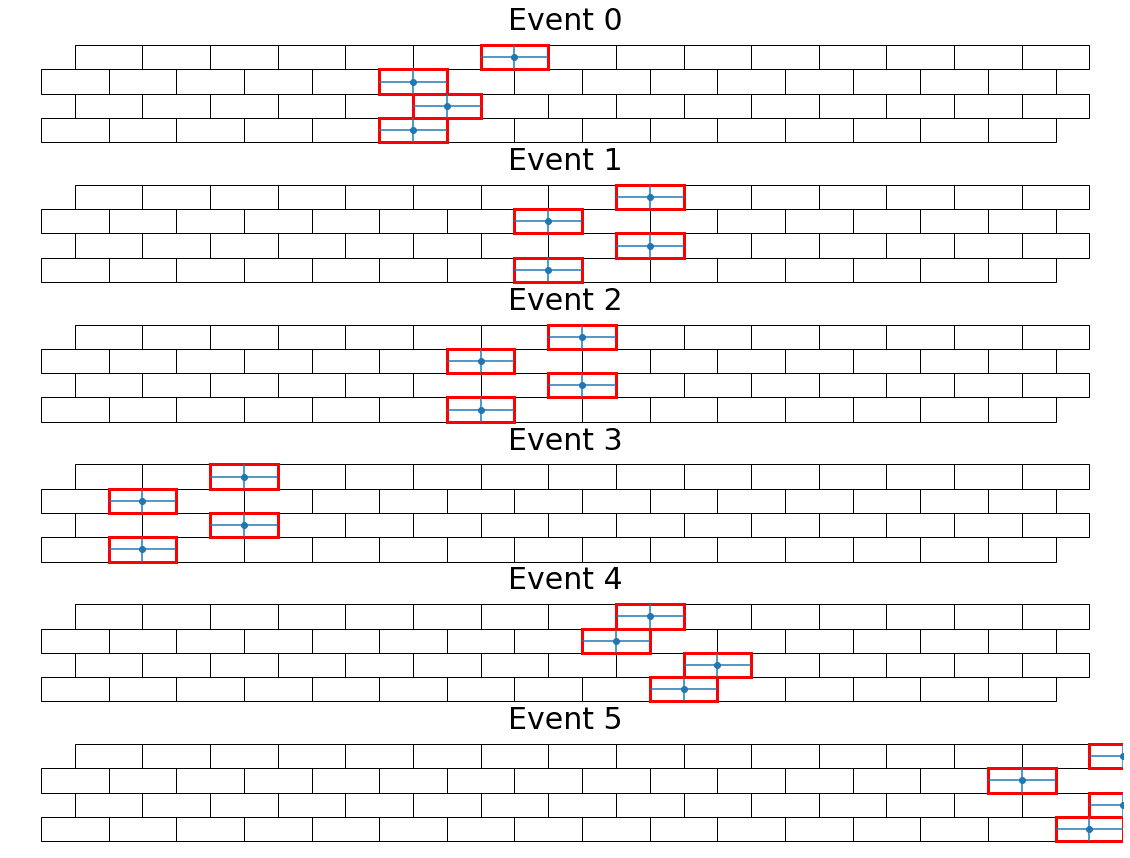

In [54]:
#draw new events
dx = 1
dy = 1/2

fig,ax = plt.subplots(nrows=6,ncols=1,figsize=(20,15))

for i in range(6):
    ax[i].set_title("Event %d" %i,fontsize=30)
    draw_detector(ax[i])
    boxes(ax[i],centres(event[i])[0],centres(event[i])[1])
    #ax[i].errorbar(centres(event[i])[0],centres(event[i])[1],dy/2,dx/2,fmt='o')
    ax[i].errorbar(*centres(event[i]),dy/2,dx/2,fmt='o') #nota mia: penso sia più elegante ed efficiente (una chiamata in meno) usare l'unpack operator *
    #poiché tecnicamente non ho testato questa modifica lascio il comando iniziale per potere tornare indietro facilmente
#traj(ax1,centres(event0)[0],centres(event0)[1])

plt.show()


Come si può notare dalle immagini precedenti, a meno di mancata ricezione di segnali, gli eventi in questa forma non possono rappresentare delle traiettorie rettilinee di una particella. Abbiamo deciso pertanto di selezionare un'ultima volta gli eventi, conservando quelli che consentono alla particella di avere una traiettoria rettilinea e scartando gli altri.

SPIEGARE COME FUNZIONA IL CRITERIO VICINANZA ORIZZONTALE

In [25]:
#SEVENTH CUT
#select only cells that are close in the detector

def close(group):
    
    group1 = group.drop(group[group['DETECTOR']==0].index)\
                  .sort_values('LAYER') #event without trigger and sorted by LAYER
    
    #distances between cells
    x = pd.Series(centres(group1)[0]).diff().abs() 
    # centres(group1)[0] sono una serie di x dei centri. diff().abs() mi restituisce un altro array della stessa dimensione di centres ma con le differenze ogni valore rispetto al precedente nell'array (il primo elemento è sempre NaN) in valore assoluto. Stessa operazione per le y
    #y=pd.Series(centres(group1)[1]).diff().abs()
    # layer tutti attivi oppure no 
    if (x>1).any() == True: 
        return None
  
    else : 
        return group
    
    
filtered7 = filtered6.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(close)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1) 


orbits7 = filtered7['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits7)
print("Samples in reduced dataset:",filtered7.shape[0])
print("Percentage of the original dataset:",filtered7.shape[0]*100/samples,"%")


filtered7

Number of unique orbits: 24912
Samples in reduced dataset: 122826
Percentage of the original dataset: 9.505729317419508 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0
...,...,...,...,...,...,...,...
122821,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0
122822,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0
122823,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0
122824,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0


In [26]:
# QUANDO BUCHI. USO LA FUNZIONE HOLE 
#if  np.countnonzero(x>1) > 1 : return None per casi brutti 

def closep(group):
    group1 = group.drop(group[group['DETECTOR'] == 0].index)\
    .sort_values('LAYER') #event without trigger and sorted by LAYER
    
    #distances between cells
    x = pd.Series(centres(group1)[0]).diff().abs() 
    #if x == [None, 1, 2] or x == [None, 2, 1]: return None #penso sia scambiato con quella finale; uso in+un set per migliori prestazioni e per rendere più chiaro il tutto - cfr https://stackoverflow.com/questions/20234935/python-in-operator-speed/20234990
    if x in {[None, 1, 2],[None, 2, 1],[None, 0, 1],[None, 1, 0]}: return group #i due casi aggiunti corrispondono a traiettorie quasi verticali.
    #comunque bisogna specificare a mano anziché chiedere che nessuno superi 2 se no i casi spuri con le celle agli estremi allineate e quella nel mezzo lontana passano. L'alternativa di contare con count_nonzero quanti superano 2 (chiedendo che questo valore sia minore di 2) non mi convince fino in fondo; se ad esempio sono nel caso 124 con 2 e 4 allineate e 1 lontana 2 unità da 2 questo passa con il count_nonzero ma è sicuramente spurio! La casistica specificata a mano contiene credo tutti i casi di interesse (rette verticali e scala) 

    #else: return group # penso sia scambiato
    else : 
        return None

#NOTA IMPORTANTE
#forse vale la pena di scartare tutto questo controllo extra sulla base della inutilità e della difficoltà ad implementarlo seriamente; mi sono accorto che quanto sopra ancora non va bene!
#Immagina di avere un caso 124 con la cella 2 una unità a destra della cella 1 e la cella 4 2 unità a sinistra della 2; questo è sicuramente spurio ma passa! allora abbiamo due alternative: o si butta tutto o si implementa anche l'informazione verticale. 
#Nota: non credo che questo problema sorga nel caso semplice con celle solo contigue: lì ho provato a costruire tutti i casi che passerebbero il filtro e anche quelli più strani sono compatibili con delle rette in linea di principio vista la larghezza dei rettangoli (ma magari non funzionano lo stesso; il test ultimo è quello delle rette, ma in ogni caso snellire al massimo prima di arrivare lì è ovviamente meglio)

In [27]:
# prima del filtro sette che utilizza la funzione della distanza orizzontale per gli eventi con quattro layer attivati. holes1 restituisce un dataframe con soltanto i casi particolari visti nella funzione hole
holes1 = filtered6.groupby(['ORBIT_CNT'],group_keys=False)\
                  .apply(hole)\
                  .dropna()\
                  .reset_index()\
                  .drop(['index'],axis=1)
holes1

""


In [28]:
try : #quanto segue fallisce se filteredholes è vuoto
    filteredholes = holes1.groupby(['ORBIT_CNT'],group_keys=False)\
                          .apply(closep)\
                          .dropna()\
                          .reset_index()\
                          .drop(['index'],axis=1)
    filtered7 = pd.concat(filtered7,filteredholes,ignore_index=True)
    orbits7 = filtered7['ORBIT_CNT'].nunique()

    print("Number of unique orbits:",orbits7)
    print("Samples in reduced dataset:",filtered7.shape[0])
    print("Percentage of the original dataset:",filtered7.shape[0]*100/samples,"%")

    filtered7
except: pass


In [29]:
# devo fare il merge dei dataframe filteredholes e filtered7
#ci ho pensato io sopra fra

La versione finale del nostro dataset corrisponde al 9% della mole di dati iniziale. Questa forte riduzione è chiaramente motivata dalla lunga serie di condizioni che abbiamo imposto sui dati, al fine di poterli rendere trattabili con l'approccio richiesto dal nostro progetto.

In [67]:
orbits = filtered7['ORBIT_CNT'].unique()
triggers_139 = filtered7[filtered7['TDC_CHANNEL']==139]
randomin = np.random.randint(10,size=6)
event = [filtered7.loc[filtered7['ORBIT_CNT']==orbits[i]].drop(triggers_139.iloc[i].name) for i in randomin]
# scelgo questa volta 6 eventi proprio casuali e li inserisco all'interno di una lista tramite list comprehension. Chiamo randomin, memorizzandolo altrimenti adogni esecuzione della cella e della successiva di plot cambierebbero gli eventi scelti, la lista di interi compresi tra zero e dieci ad esempio lunga 6.
event[0]

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
25,9.0,1.897418e+09,2540.0,12.0,63510.000000,3.0,4.0
26,12.0,1.897418e+09,2540.0,19.0,63515.833333,3.0,1.0
27,11.0,1.897418e+09,2547.0,6.0,63680.000000,3.0,3.0
28,10.0,1.897418e+09,2551.0,17.0,63789.166667,3.0,2.0


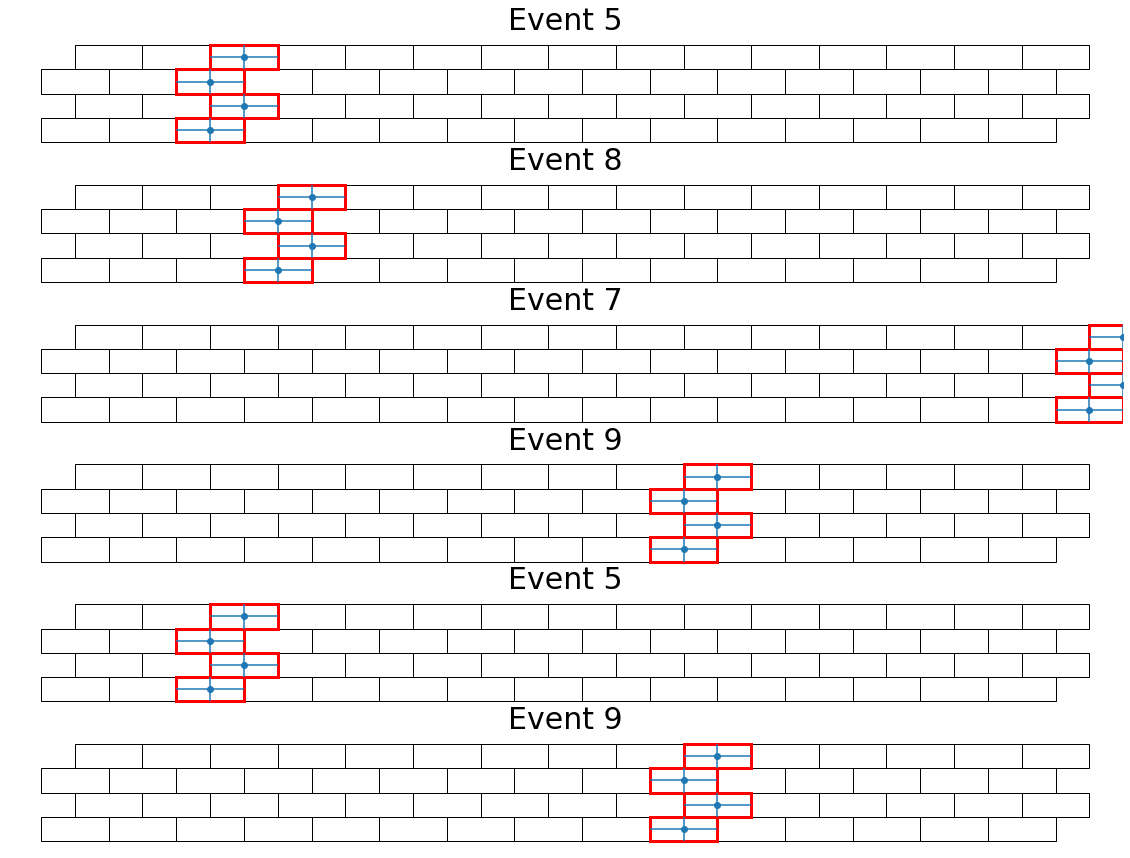

In [68]:
#draw new events
dx = 1
dy = 1/2

fig,ax = plt.subplots(nrows=6,ncols=1,figsize=(20,15))

for i,j in zip(range(6), randomin):
    ax[i].set_title("Event %d" %j,fontsize=30)
    draw_detector(ax[i])
    boxes(ax[i],centres(event[i])[0],centres(event[i])[1])
    #ax[i].errorbar(centres(event[i])[0],centres(event[i])[1],dy/2,dx/2,fmt='o')
    ax[i].errorbar(*centres(event[i]),dy/2,dx/2,fmt='o') #vedi la cella precedente a questa dove si fa il disegno per capire questa riga vs la precedente

plt.show()

In [32]:
stop = time.time()
print("total execution time:",stop-start,"s,","i.e.",(stop-start)/60,"min")

total execution time: 440.126868724823 s, i.e. 7.335447812080384 min


CHANGELOG
aggiunte rispetto a Samuele: 
- cronometro globale
- try per proteggere la cella relativa ai casi bucati + concatenazione ivi aggiunta in caso favorevole + passaggio a in anziché doppio confronto (equivalente o migliore, pare; vedi commento in loco) + aggiunti altri casi buoni che c'eravamo persi all'inizio
- inserito abbozzo di funzione più generale ed elegante per rappresentare eventi selezionati, vedi cella relativa per info
- inserita nota importante a favore del buttare closep
- aggiunto ottavo taglio basato su Tmax; vedi qui sotto
- ritoccato il ntriggers_mask nella prima cella nonbanale per usare meno memoria ma soprattutto perché il mio ritardo mi impone di provare fastidio vedendo quella asimmetria; altri ritocchi "grammaticali" qua e là

In [33]:
#questa cella impiega circa 20 secondi, quindi la stima di stop-start fatta sopra va comunque bene

#OTTAVO TAGLIO 
#come sanity check controlliamo che la durata di un dato evento non superi Tmax

def filter_by_event_duration(group) :
    Tmax = 390
    
    group1 = group.drop(group[group['DETECTOR']==0].index) #rimuovo i trigger, che non rappresentano hits associate ad un dato evento
    if (group1.TIME.max() - group1.TIME.min()) > Tmax :
        return None 
    else :
        return group


filtered8 = filtered7.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(filter_by_event_duration)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)

orbits8 = filtered8['ORBIT_CNT'].nunique()

print("Number of unique orbits:",orbits8)
print("Samples in reduced dataset:",filtered8.shape[0])
print("Percentage of the original dataset:",filtered8.shape[0]*100/samples,"%")

print("accounting by event duration decreased the number of potentially valid events by:",(filtered7.shape[0]-filtered8.shape[0])/filtered7.shape[0]*100,"%")

filtered8

#i filtri della sopra e guardare il tempo totale di esecuzione, però:
# - adesso non ho la pazienza di rieseguire altri 9 minuti di cose più volte
# - visto che questo filtro è indipendente da tutti gli altri dove conviene metterlo? All'inizio? Dopo il primo? Subito prima di quello delle distanze orizzontali? Boh. ora mi secco a provareella sopra e guardare il tempo totale di esecuzione, però:
# - adesso non ho la pazienza di rieseguire altri 9 minuti di cose più volte
# - visto che questo filtro è indipendente da tutti gli altri dove conviene metterlo? All'inizio? Dopo il primo? Subito prima di quello delle distanze orizzontali? Boh. ora mi secco a provare

Number of unique orbits: 24855
Samples in reduced dataset: 122550
Percentage of the original dataset: 9.484369171427554 %
accounting by event duration decreased the number of potentially valid events by: 0.22470812368716722 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0
...,...,...,...,...,...,...,...
122545,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0
122546,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0
122547,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0
122548,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0


In [34]:
#filtered8.to_csv("dati_LS.csv",index=False)